## Cell 1 — Environment Setup and Library Imports

This cell installs and imports all required Python packages for network analysis and visualization:
- `networkx` for graph data structures and algorithms  
- `numpy` for numerical computation  
- `matplotlib` for graph visualization  
- `pandas` for tabular metric storage  

Also configures plot settings (`%matplotlib inline`) and warning suppression for consistent output.


In [99]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import warnings       #just importing important PACKAGES

%matplotlib inline
warnings.filterwarnings("ignore")

print("Libraries loaded successfully.")


Libraries loaded successfully.


## Cell 2 - Load and Visualize the Karate Club Network

Loads Zachary's Karate Club graph using networkx.karate_club_graph().
Displays the base network with node labels and edges using a fixed spring_layout 
to ensure consistent node positioning throughout all iterations.


G = nx.karate_club_graph()                   #generating the karate club graph
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Graph loaded successfully: {n} nodes, {m} edges")

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(7,7))
nx.draw(G, pos, with_labels=True, node_color="lightblue",     
        edge_color="gray", node_size=600, font_size=10)
plt.title("Zachary's Karate Club Graph")
plt.show()


## Cell 3 - Define Modularity Matrix Function

Defines the modularity matrix:

B_ij = A_ij - (k_i * k_j) / (2m)

where:
- A_ij is the adjacency matrix entry,
- k_i is the degree of node i,
- m is the total number of edges.

This matrix measures how much the observed edge structure deviates from a random null model, 
forming the foundation for modularity-based community detection.


In [101]:
def modularity_matrix(G):                        #creating the modularity matrix B
    A = nx.to_numpy_array(G)
    k = np.array([deg for _, deg in G.degree()])
    m = G.number_of_edges()
    if m == 0:
        return np.zeros_like(A)
    B = A - np.outer(k, k) / (2 * m)
    B = B - np.diag(B.sum(axis=1))  
    return B


## Cell 4 - Compute Leading Eigenpair

Implements a helper function to extract the largest eigenvalue (lambda_1)
and its corresponding eigenvector (u_1) from the modularity matrix B.

The sign of each element of u_1 determines community assignment:


In [102]:
def leading_eigenpair(B):                           # taking the largest eigen value and its corresponding vector
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argmax(eigvals)
    return eigvals[idx], eigvecs[:, idx]


## Cell 5 - Recursive Modularity Bisection with Visualization and Metrics

Performs recursive spectral partitioning as follows:
1. Start with all nodes in one group.
2. Compute the modularity matrix for the subgraph.
3. Find (lambda_1, u_1) and split based on the sign of u_1.
4. Continue recursively until no group can be split further (lambda_1 <= tolerance).

Also computes and stores centrality metrics (degree, betweenness, closeness, clustering)
for every iteration, and visualizes community formation .

### Logic of the Recursive Function
At each step, the function calculated the modularity matrix:
B_ij = A_ij - (k_i * k_j) / (2m)
Then it found the largest eigenvalue (lambda_1) and its eigenvector (u_1). Nodes with positive u_1 values were put in one group, and the rest in another. If the split improved modularity (lambda_1 > 0), the process continued for each new group. If not, the group was considered final


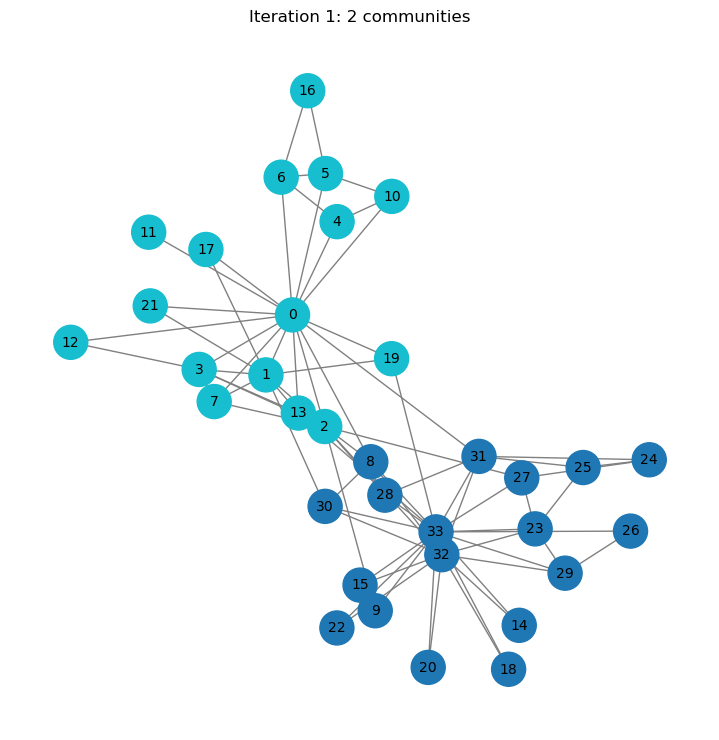

Step 1: λ₁=2.8314 → split 34 → 18 + 16


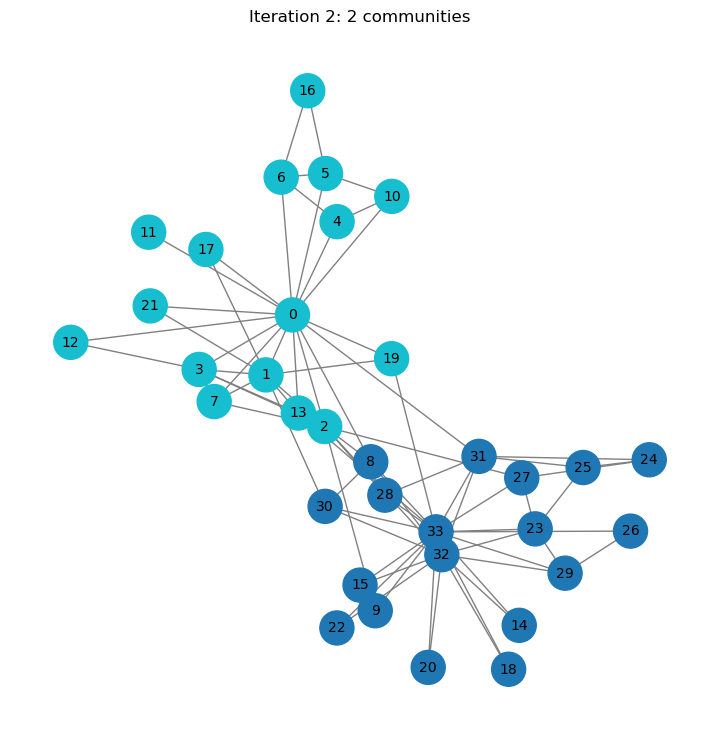

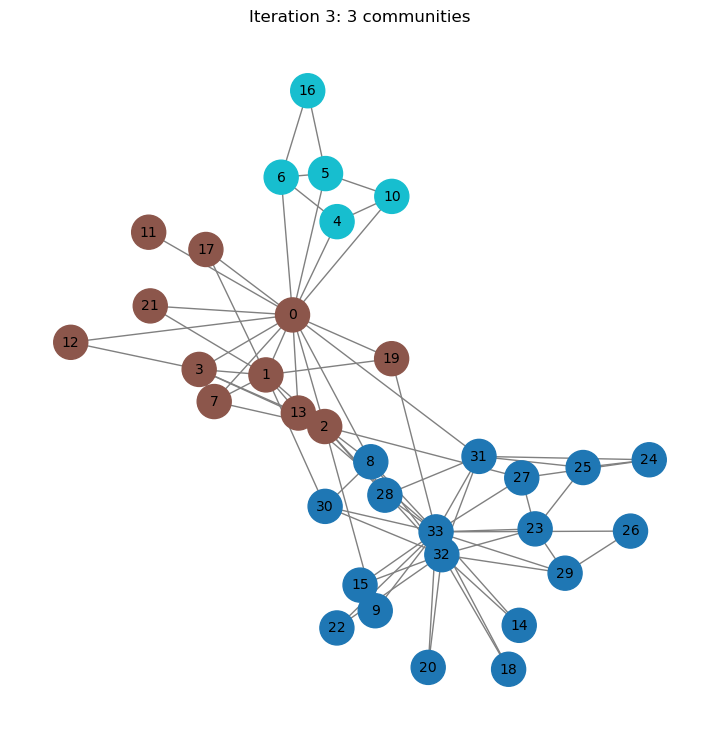

Step 3: λ₁=1.2087 → split 16 → 11 + 5


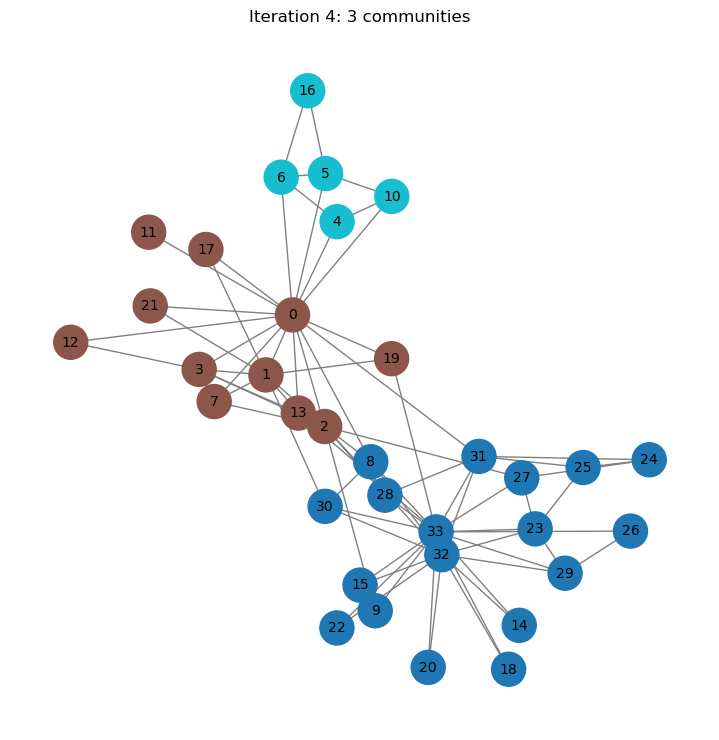

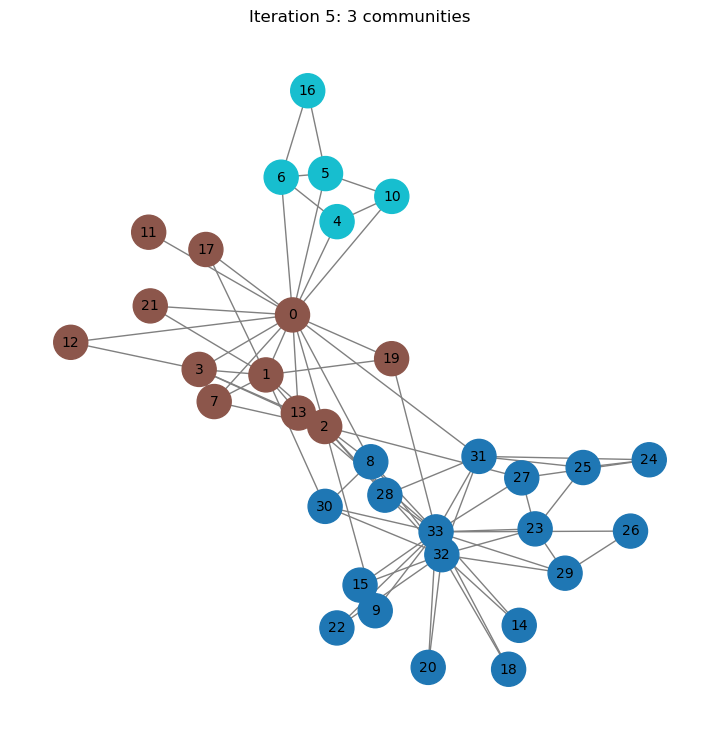


 Final number of detected communities: 3


In [103]:
def draw_iteration(G, communities, iteration):                 #function to draw the graph at different iteration to show the formation of communities
    pos = nx.spring_layout(G, seed=42)
    cmap = plt.colormaps["tab10"]

    color_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            color_map[node] = i

    node_colors = [cmap(color_map[node] / max(1, len(communities)-1)) for node in G.nodes()]

    plt.figure(figsize=(7,7))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        edge_color="gray",
        node_size=600,
        font_size=10
    )
    plt.title(f"Iteration {iteration}: {len(communities)} communities")
    plt.show()


def recursive_partition_visual(G):                     # function that splits the graph into communities recursively in the basis of the eigen value
    queue = [list(G.nodes())]                           # for a vertex n if nth component of the eigen vector is +ve then it is in plus else in minus
    communities = []
    all_partitions = []
    metrics_history = []  
    step = 1

    while queue:
        nodes = queue.pop(0)
        subG = G.subgraph(nodes)
        iter_metrics = {"degree": {}, "betweenness": {}, "closeness": {}, "clustering": {}}
        current_partition = communities + [nodes] + queue  # all groups being considered now
        for group in current_partition:
            sg = G.subgraph(group)
            if len(group) > 1:
                deg = nx.degree_centrality(sg)
                bet = nx.betweenness_centrality(sg)
                clo = nx.closeness_centrality(sg) if nx.is_connected(sg) else {n:0.0 for n in sg}
                clu = nx.clustering(sg)
                iter_metrics["degree"].update(deg)
                iter_metrics["betweenness"].update(bet)                                          #saves different values of the centrality of all the nodes
                iter_metrics["closeness"].update(clo)                                            # in a list called metrics_history
                iter_metrics["clustering"].update(clu)
            else:
                n = group[0]
                for key in iter_metrics.keys():
                    iter_metrics[key][n] = 0.0
        metrics_history.append(iter_metrics)
        
        if len(nodes) <= 1:
            communities.append(nodes)
            all_partitions.append(communities + queue)               #to make sure a partition will have minimum two nodes
            draw_iteration(G, communities + queue, step)
            step += 1
            continue

        B_sub = modularity_matrix(subG)                          #generating the modularity matrix
        lambda1, u1 = leading_eigenpair(B_sub)                   #finding the eigen values

        if lambda1 <= 1e-6:
            communities.append(nodes)                          # to make sure the eigen value is positive
            all_partitions.append(communities + queue)
            draw_iteration(G, communities + queue, step)
            step += 1
            continue

        plus = [nodes[i] for i, val in enumerate(u1) if val > 0]    #dividing the graph into plus and minus communities
        minus = [nodes[i] for i, val in enumerate(u1) if val <= 0]

        if not plus or not minus:
            communities.append(nodes)
            all_partitions.append(communities + queue)     # to check if it actually partitions the nodes in plus or minus and making suure not all of it went to one list
            draw_iteration(G, communities + queue, step)    # make sure neither plus nor minus is a empty list
            step += 1
            continue

        queue.append(plus)
        queue.append(minus)
        all_partitions.append(communities + queue)
        draw_iteration(G, communities + queue, step)
        print(f"Step {step}: λ₁={lambda1:.4f} → split {len(nodes)} → {len(plus)} + {len(minus)}")
        step += 1

    return communities, all_partitions, metrics_history

communities_visual, partitions, metrics_history = recursive_partition_visual(G)
print(f"\n Final number of detected communities: {len(communities_visual)}")


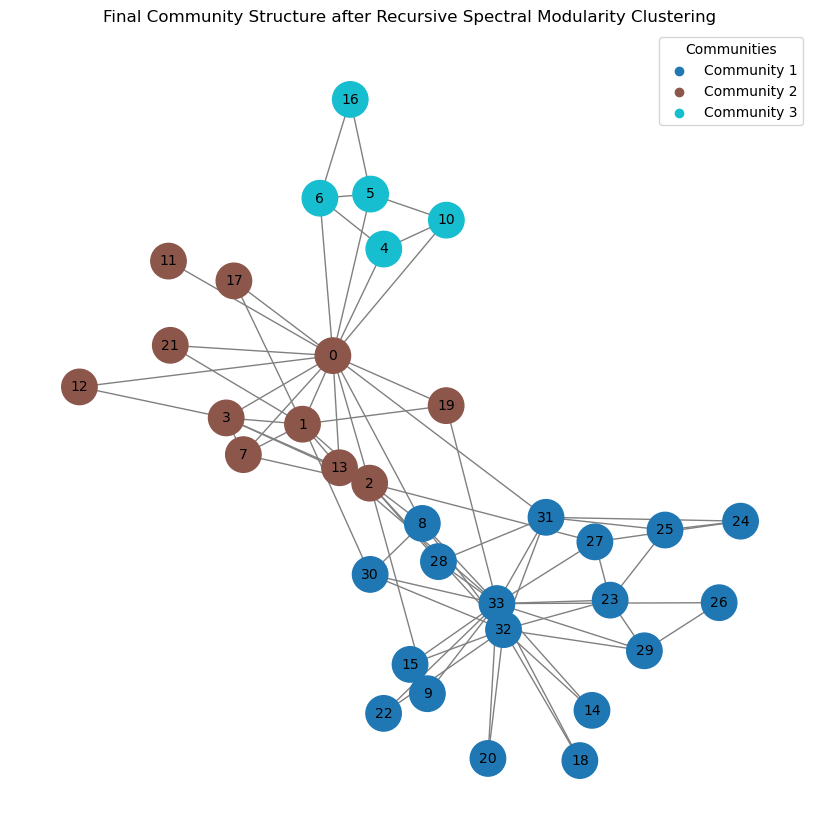

In [104]:
def draw_final_communities(G, communities, title="Final Community Structure"):
    pos = nx.spring_layout(G, seed=42)
    cmap = plt.colormaps["tab10"]

    color_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            color_map[node] = i

    node_colors = [cmap(color_map[node] / max(1, len(communities)-1)) for node in G.nodes()] # just drawes the final graph with all the possible communities

    plt.figure(figsize=(8,8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            edge_color="gray", node_size=650, font_size=10)
    for i in range(len(communities)):
        plt.scatter([], [], c=[cmap(i / max(1, len(communities)-1))],
                    label=f"Community {i+1}")
    plt.legend(title="Communities")
    plt.title(title)
    plt.show()

draw_final_communities(G, communities,
                       "Final Community Structure after Recursive Spectral Modularity Clustering")


In [105]:
metrics = {
    "degree": nx.degree_centrality(G),                       #print the final centrality of all the 34 nodes in the graph
    "betweenness": nx.betweenness_centrality(G),
    "closeness": nx.closeness_centrality(G),
    "clustering": nx.clustering(G)
}

df_metrics = pd.DataFrame(metrics)
df_metrics.head(34)


,degree,betweenness,closeness,clustering
0,0.484848,0.437635,0.568966,0.150000
1,0.272727,0.053937,0.485294,0.333333
2,0.303030,0.143657,0.559322,0.244444
3,0.181818,0.011909,0.464789,0.666667
4,0.090909,0.000631,0.379310,0.666667
5,0.121212,0.029987,0.383721,0.500000
6,0.121212,0.029987,0.383721,0.500000
7,0.121212,0.000000,0.440000,1.000000
8,0.151515,0.055927,0.515625,0.500000
9,0.060606,0.000848,0.434211,0.000000


In [106]:
for i, comm in enumerate(communities):
    subset = df_metrics.loc[comm]
    print(f"\nCommunity {i+1} (Size {len(comm)}): Nodes {sorted(comm)}")  #prints the mean centrality of the 3 communities
    print(subset.mean().to_string(float_format=lambda x: f"{x:.4f}"))



Community 1 (Size 18): Nodes [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
degree        0.1347
betweenness   0.0394
closeness     0.4260
clustering    0.5411

Community 2 (Size 11): Nodes [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
degree        0.1653
betweenness   0.0660
closeness     0.4565
clustering    0.5753

Community 3 (Size 5): Nodes [4, 5, 6, 10, 16]
degree        0.0970
betweenness   0.0122
closeness     0.3621
clustering    0.6667


## Cell 6 - Plot Centrality Evolution (Colored by Final Community)

Plots how each node's centrality metrics evolve during recursive partitioning:
- Degree centrality: measures connection density
- Betweenness centrality: measures control over information flow
- Closeness centrality: measures how close a node is to all others
- Clustering coefficient: measures local clustering strength

Each node is color-coded by its final community (red, blue, yellow),
and community leaders (Node 0 and Node 33) are highlighted with dashed lines.


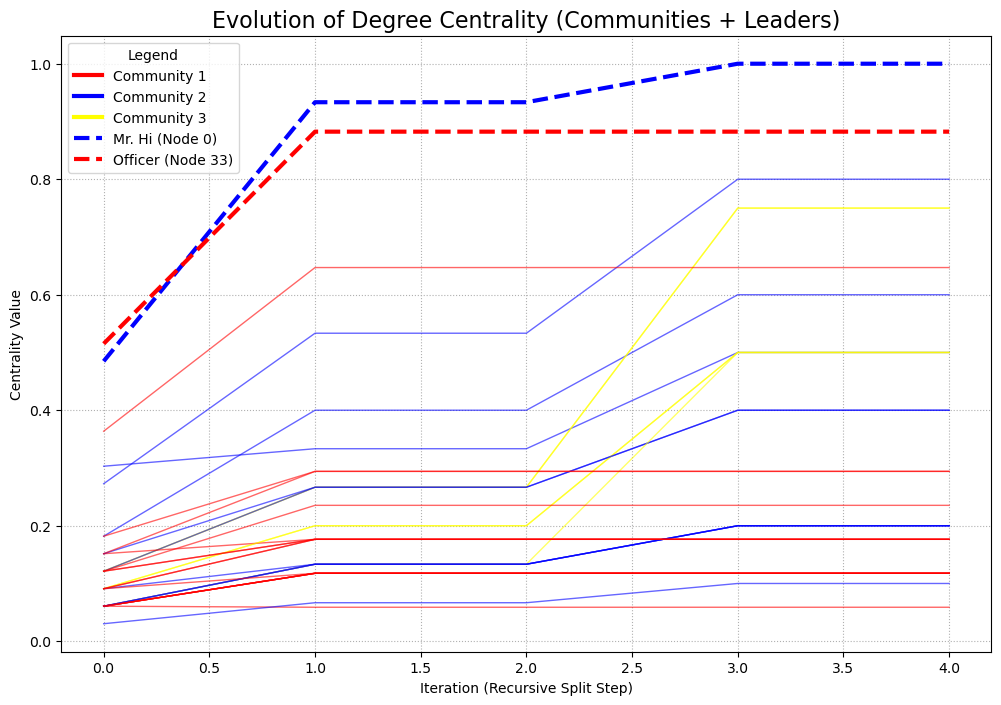

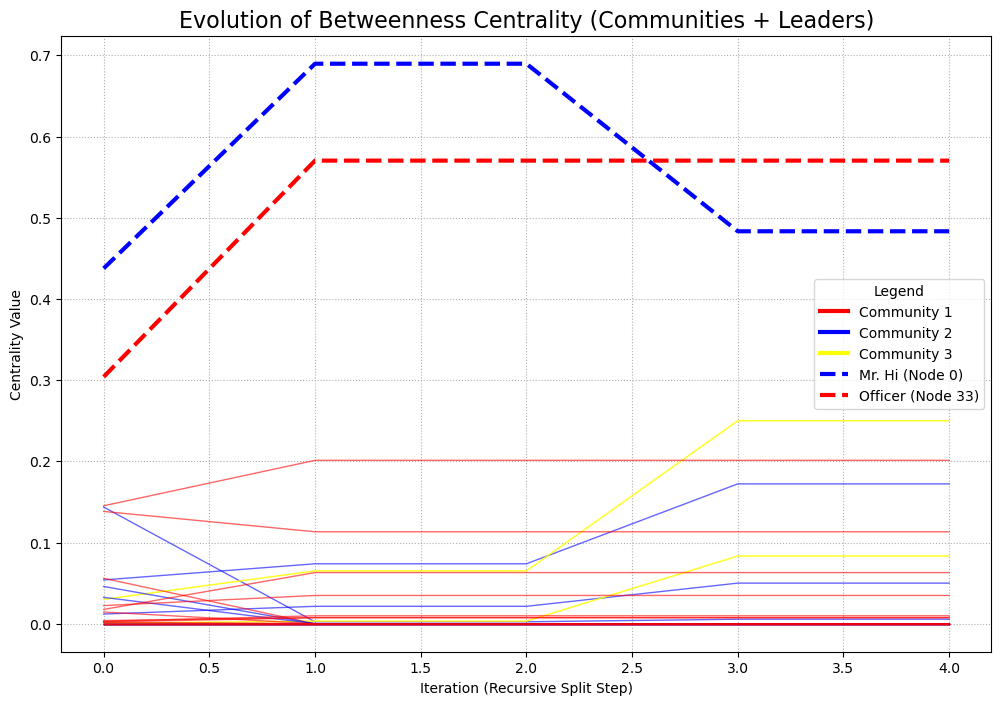

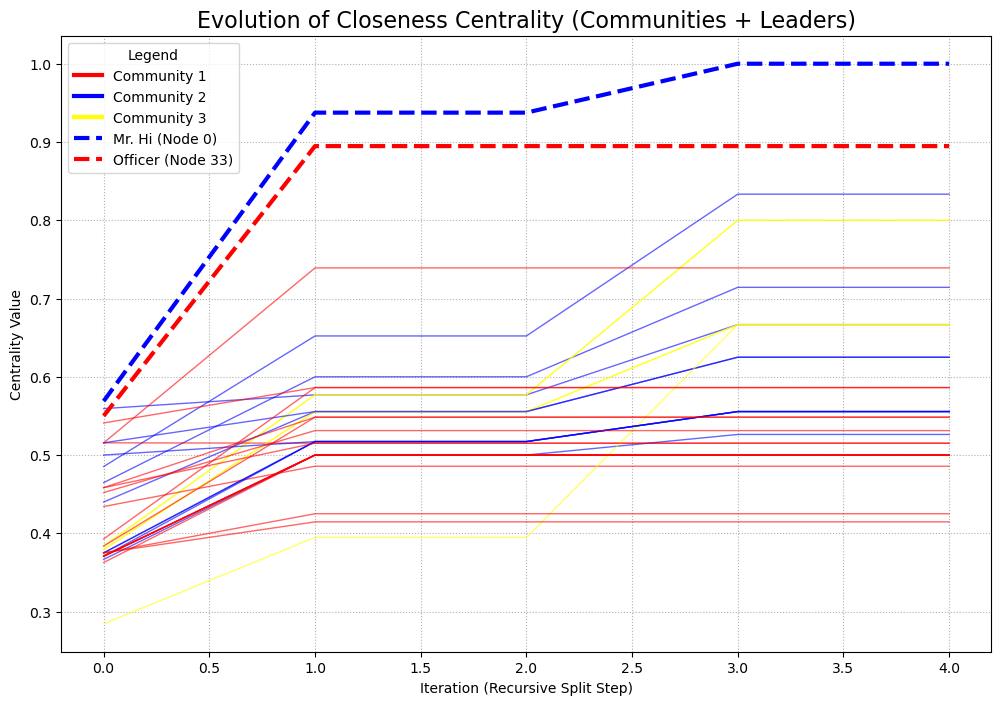

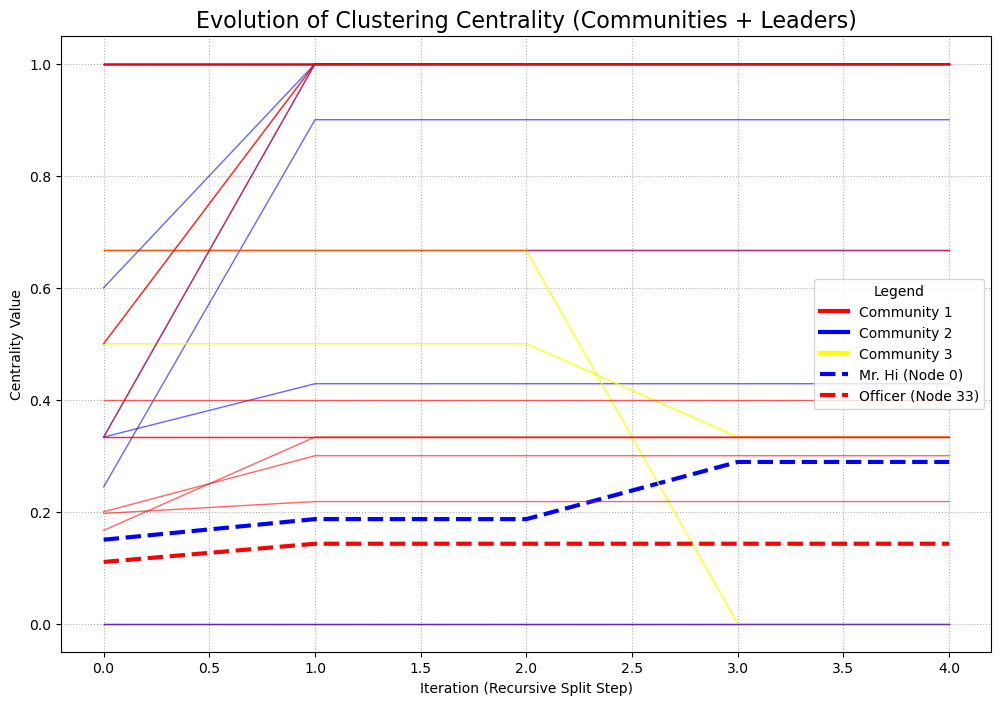

In [107]:
def plot_metric_evolution_by_community(G, metrics_history, communities):
    iteration_ticks = list(range(len(metrics_history)))

   
    fixed_colors = ["red", "blue", "yellow"]


    node_to_color = {}
    for i, comm in enumerate(communities):
        color = fixed_colors[i % len(fixed_colors)]   #plots how the centrality of the 34 nodes changes with the iterations and the change in the community they belong to
        for node in comm:
            node_to_color[node] = color

    
    leaders = {0: "Mr. Hi", 33: "Officer"}

   
    for metric_name in ["degree", "betweenness", "closeness", "clustering"]:
        plt.figure(figsize=(12, 8))

        for node in G.nodes():
            
            values = [metrics[metric_name].get(node, 0) for metrics in metrics_history]
            color = node_to_color.get(node, "gray")

            if node in leaders:
                plt.plot(
                    iteration_ticks,
                    values,
                    color=color,
                    lw=3,
                    linestyle='--',
                    label=f"Node {node} ({leaders[node]})"
                )
            else:
                plt.plot(
                    iteration_ticks,
                    values,
                    color=color,
                    lw=1,
                    alpha=0.6
                )

        plt.title(f"Evolution of {metric_name.title()} Centrality (Communities + Leaders)", fontsize=16)
        plt.xlabel("Iteration (Recursive Split Step)")
        plt.ylabel("Centrality Value")
        plt.grid(True, linestyle=":")

        from matplotlib.lines import Line2D
        legend_lines = []

        for i, comm in enumerate(communities):
            legend_lines.append(Line2D(
                [0], [0],
                color=fixed_colors[i % len(fixed_colors)],
                lw=3,
                label=f"Community {i+1}"
            ))

        for node, name in leaders.items():
            legend_lines.append(Line2D(
                [0], [0],
                color=node_to_color.get(node, "black"),
                lw=3,
                linestyle='--',
                label=f"{name} (Node {node})"
            ))

        plt.legend(handles=legend_lines, title="Legend", loc="best", frameon=True)
        plt.show()


plot_metric_evolution_by_community(G, metrics_history, communities_visual)



## Discussion

### Community Structure
The recursive spectral modularity method divided the Karate Club network into clear groups that match the real-life split between Mr. Hi’s group and the Officer’s group. Each step used the leading eigenvector of the modularity matrix to decide how to split nodes, and the process stopped when no further split could increase modularity. This shows how well the algorithm can find natural divisions in a network based on connection patterns.

### Metric Evolution
During the splitting process, four node metrics were tracked — degree, betweenness, closeness, and clustering. Node 0 (Mr. Hi) and Node 33 (Officer) showed the highest centrality values, confirming their roles as leaders of their communities. The other nodes’ metrics changed more gradually as the algorithm refined the groups, showing that the community structure became more stable with each step.

### Conclusion
Overall, the recursive modularity approach worked well for detecting the main communities in the Karate Club network. Tracking centrality changes helped show how important nodes influence the network as it splits into smaller parts. The method gives a clear picture of both the community structure and how leadership roles form within it.
